<span style="color:darkblue"><font size="6"> DeCockHousePrice Dataset: Saleprice Prediction</font></span> 
 

In [661]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

In [662]:
df=pd.read_csv('data/train.csv')

# Data Cleaning 

In [663]:
#filling missing data according to data types and concrete meaning
cg_cols = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
dc_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']
ot_cols = ['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities']
for col in dc_cols:
    df[col].replace(np.nan, 0, inplace=True)

for col in cg_cols:
    df[col].replace(np.nan, 'None', inplace=True)

for col in ot_cols:
    df[col].replace(np.nan, df[col].mode()[0], inplace=True)
    
# Filling MSZoning according to MSSubClass
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))

# Filling LotFrontage according to Neighborhood

df['LotFrontage']=df.groupby(['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [ ]:
##These outliers could be deleted to get better outcome, but keeping them there is also ok, as
#training a robust model is feasible
# train = train.drop(train[(train['OverallQual'] < 5)
#                                   & (train['SalePrice'] > 200000)].index)
# train = train.drop(train[(train['GrLivArea'] > 4000)
#                                   & (train['SalePrice'] < 200000)].index)
# train = train.drop(train[(train['GarageArea'] > 1200)
#                                   & (train['SalePrice'] < 200000)].index)
# train = train.drop(train[(train['TotalBsmtSF'] > 3000)
#                                   & (train['SalePrice'] > 320000)].index)
# train = train.drop(train[(train['1stFlrSF'] < 3000)
#                                   & (train['SalePrice'] > 600000)].index)
# train = train.drop(train[(train['1stFlrSF'] > 3000)
#                                   & (train['SalePrice'] < 200000)].index)

In [664]:
# Feature which is numerical but should be treated as category.
df['MSSubClass'] = df['MSSubClass'].astype(str)

In [665]:
# cyclical feature transformation
from math import pi
df['MoSold']=2*pi*df['MoSold']/df['MoSold'].max()
df["cos_MoSold"] = np.cos(df["MoSold"])
df["sin_MoSold"] = np.sin(df["MoSold"])

In [666]:
df.drop('MoSold',axis=1,inplace=True)

df.drop('Id',axis=1,inplace=True)

#binning with rare values
col_rare = ['Condition1', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'Heating', 'Electrical', 'Functional', 'SaleType']
for col in col_rare:
    mask = df[col].isin(
        df[col].value_counts()[df[col].value_counts() < 10].index)
    df[col][mask] = 'Other'

In [669]:
# encoding ordinal categorical variables
neigh_map={'MeadowV': 1,'IDOTRR': 1,
    'BrDale': 1, 'BrkSide': 2,
    'OldTown': 2, 'Edwards': 2,
    'Sawyer': 3,    'Blueste': 3,
    'SWISU': 3,    'NPkVill': 3,
    'NAmes': 3,    'Mitchel': 4,
    'SawyerW': 5,    'NWAmes': 5,
    'Gilbert': 5,    'Blmngtn': 5,
    'CollgCr': 5,    'ClearCr': 6,
    'Crawfor': 6,    'Veenker': 7,
    'Somerst': 7,    'Timber': 8,
    'StoneBr': 9,    'NridgHt': 10,
    'NoRidge': 10}
    
df['Neighborhood'] = df['Neighborhood'].map(neigh_map).astype('int')

ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['ExterCond'] = df['ExterCond'].map(ext_map).astype('int')
df['ExterQual'] = df['ExterQual'].map(ext_map).astype('int')

bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['BsmtQual'] = df['BsmtQual'].map(bsm_map).astype('int')
df['BsmtCond'] = df['BsmtCond'].map(bsm_map).astype('int')
bsmf_map = {'None': 0, 'Unf': 1,'LwQ': 2,'Rec': 3, 'BLQ': 4, 'ALQ': 5,'GLQ': 6}

df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmf_map).astype('int')
df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['HeatingQC'] = df['HeatingQC'].map(heat_map).astype('int')
df['KitchenQual'] = df['KitchenQual'].map(heat_map).astype('int')
df['FireplaceQu'] = df['FireplaceQu'].map(bsm_map).astype('int')
df['GarageCond'] = df['GarageCond'].map(bsm_map).astype('int')
df['GarageQual'] = df['GarageQual'].map(bsm_map).astype('int')

In [670]:
df["logSalePrice"]=np.log(df["SalePrice"])

df.drop('SalePrice',axis=1,inplace=True)

# Getting dummy variables for nominal categorical features
df = pd.get_dummies(data=df)

In [673]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 214 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(6), int64(43), uint8(165)
memory usage: 794.3 KB


In [674]:
df.head()

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_COD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,5,7,5,2003,2003,196.0,4,3,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,7,6,8,1976,1976,0.0,3,3,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,5,7,5,2001,2002,162.0,4,3,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,6,7,5,1915,1970,0.0,3,3,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,10,8,5,2000,2000,350.0,4,3,...,0,0,0,1,0,0,0,0,1,0


# Feature Selection
    - Based on correlation
    
    - Based on P-value

In [764]:
corr = df.corr()
corr.head()

,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,MiscFeature_TenC,SaleType_COD,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal
LotFrontage,1.000000,0.335957,0.250274,0.239546,-0.043595,0.120999,0.084550,0.195830,0.166857,-0.006124,...,0.011442,-0.004261,0.122643,-0.017725,-0.090900,-0.014946,-0.036696,-0.018572,0.013666,-0.073047
LotArea,0.335957,1.000000,0.168539,0.105806,-0.005636,0.014228,0.013788,0.103321,0.055570,0.014732,...,0.016203,-0.016019,0.020039,-0.015026,-0.002292,-0.029126,-0.013208,0.008966,-0.010781,0.005711
Neighborhood,0.250274,0.168539,1.000000,0.684318,-0.219006,0.647928,0.506673,0.402346,0.652067,-0.062696,...,0.005388,-0.068483,0.327229,-0.032468,-0.220026,-0.090647,-0.053492,-0.024682,-0.045602,-0.150234
OverallQual,0.239546,0.105806,0.684318,1.000000,-0.091932,0.572323,0.550684,0.407252,0.726278,0.013953,...,0.017056,-0.065259,0.327412,-0.024494,-0.225013,-0.103535,-0.041677,-0.044950,-0.025515,-0.143282
OverallCond,-0.043595,-0.005636,-0.219006,-0.091932,1.000000,-0.375983,0.073741,-0.125694,-0.138942,0.389163,...,-0.013540,-0.028186,-0.156175,-0.054364,0.163684,-0.046367,-0.038888,-0.033444,-0.023873,0.161642


In [765]:
#Remove one of two features that have a correlation higher than 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df.columns[columns]

In [766]:
df = df[selected_columns]

selected_columns

selected_columns=selected_columns.tolist()
# .remove('logSalePrice')

selected_columns.remove('logSalePrice')

selected_columns=np.array(selected_columns)


numpy.ndarray

In [767]:
import statsmodels.regression.linear_model as sm

In [768]:
X=df.drop('logSalePrice',axis=1).values
y=df.loc[:,'logSalePrice'].values

In [769]:
numVars = df.shape[1]-1
for i in range(0, numVars):
    regressor_OLS = sm.OLS(y, X).fit()
    maxVar = max(regressor_OLS.pvalues).astype(float)
    if maxVar > 0.05:
        for j in range(0, numVars - i):
            if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                X = np.delete(X, j, 1)
                selected_columns = np.delete(selected_columns, j)

In [848]:
selected_columns.size
# selected_columns

89

# Data Scaling

In [850]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
X = minmax.fit_transform(X)

# Linear model training and evaluation

In [854]:
# As sample size is small(1460) and feature dimention is high(89), simple train_test_split
# is not a proper strategy, K_fold will be a much better choice!
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,random_state=0)
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [855]:
regressor.score(X_train,y_train)

0.9256519430279607

In [856]:
regressor.score(X_test,y_test)

0.8636774818915354

In [858]:
# K_fold outcomes are more reliable, Obvious variance problem is shown here!
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
regressor_model = LinearRegression()
regressor_model.fit(X, y,)
print(cross_val_score(regressor_model,X, y,cv=5))

[ 9.12306539e-01  8.88807766e-01 -3.19009011e+16 -5.74966349e+18
 -7.04788145e+19]


In [778]:
# As previous model give us obvious variance problem, regularization is necessary  
from sklearn.linear_model import Lasso
regressor = Lasso(alpha=0.004,max_iter=1000)
regressor.fit(X_train, y_train)

Lasso(alpha=0.004, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [779]:
regressor.score(X_train,y_train)

0.870800990768916

In [780]:
regressor.score(X_test,y_test)

0.8740070196238973

In [863]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
regressor_model = Lasso(alpha=0.004,max_iter=1000)
regressor_model.fit(X, y,)
print(cross_val_score(regressor_model,X, y,cv=5))

[0.87281157 0.85190472 0.85515311 0.85363219 0.83421146]


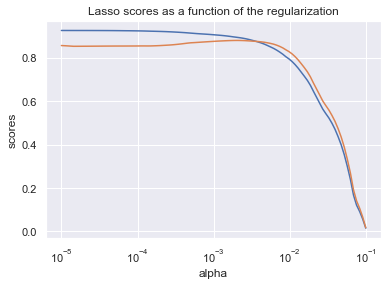

In [701]:
# Searching for a best alpha value
n_alphas = 100
alphas = np.logspace(-5, -1, n_alphas)
train_scores = []
test_scores=[]
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    train_scores.append(lasso.score(X_train,y_train))
    test_scores.append(lasso.score(X_test,y_test))
ax = plt.gca()

ax.plot(alphas, train_scores,)
ax.plot(alphas, test_scores)
ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('scores')
plt.title('Lasso scores as a function of the regularization')
plt.axis('tight')
plt.show()

<span style="color:blue"><font size="4"> Regularization has solved variance problem, but bias still exists,feature engineering is necessary</font></span> 

# Solution 1: Feature Transformation: Polynomial
   

In [702]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 2,interaction_only=True)
X_poly = poly_reg.fit_transform(X)

<span style="color:blue"><font size="4"> This dataset already has high dimentional features, polynomial regression didn't bring
    any performance improvement</font></span>  

In [703]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.3,random_state=0)
from sklearn.linear_model import Lasso
regressor = Lasso(alpha=0.0048)
regressor.fit(X_train, y_train)

Lasso(alpha=0.0048, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [704]:
regressor.score(X_train,y_train)

0.870772003552444

In [705]:
regressor.score(X_test,y_test)

0.8626932500353699

# Solution 2: Feature Transformation: PCA
   

In [880]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)

pca_X = pca.fit_transform(X)

In [881]:
pca_X.shape

(1460, 30)

In [882]:
pca.explained_variance_ratio_.sum()

0.8745665788961108

In [883]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pca_X, y, test_size = 0.3)
from sklearn.linear_model import Ridge
regressor = Ridge(alpha=0.01)
regressor.fit(X_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [884]:
pca_X.shape

(1460, 30)

In [885]:
regressor.score(X_train,y_train)

0.855512846223663

In [886]:
regressor.score(X_test,y_test)

0.863709577059506

In [888]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
regressor_model = Ridge(alpha=0.01)
print(cross_val_score(regressor_model,pca_X, y,cv=10))

[0.8327186  0.8808096  0.88529223 0.83239256 0.84976769 0.87146954
 0.8284339  0.87766892 0.78017591 0.8644597 ]


 <span style="color:blue"><font size="6"> PCA + LinearRegression ≈ Lasso</font></span>
 
 - by tuning n_components value for PCA
 - by tuning alpha value for Lasso

# problem analysis
    The model is still underfitted, two feature transformation strategies didn't solve the problem

# solution
- Collect more valuable features
- Manully and reasonablly creat new features from present features in stead of simple polynomial transformation
- Change feature selection strategy
- more complex model, Tree or SVM

In [893]:
np.random.geometric(p=0.01,size=(8,9))

array([[  2,  22,  55, 393,  56, 194,  33,  66,  31],
       [ 32,  59, 274,  34, 177,  38, 215,  21,   9],
       [ 18, 130,  73, 286,  44, 124,  75,  10,  21],
       [  9, 103,  54,  38,  14,  70,  16,  63, 124],
       [ 40,   3,  58,  63, 109,  15, 150, 157, 176],
       [  1, 224,  18,  37,  60,  33, 297, 118,  64],
       [ 77, 127, 130, 158, 161,   7, 386,  11,  51],
       [131,  28, 343,  97, 446,  37,  33, 318, 124]])